In [1]:
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
from matplotlib import pyplot

# load data
df = pd.read_csv('data/BTC-all Standardization.csv', header=0, index_col=0)
df=df['Adj Close']

In [2]:
# summarize shape
print(df.shape)

(3182,)


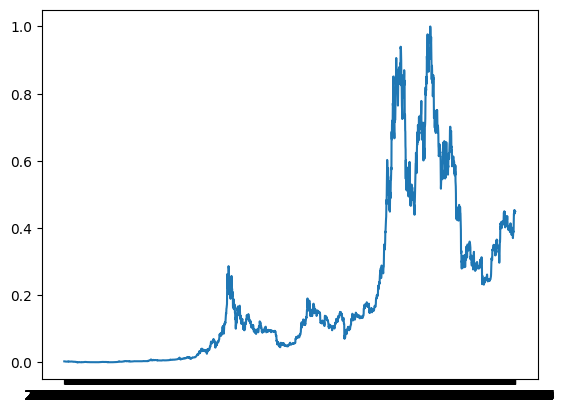

In [3]:
# plot
pyplot.plot(df)
pyplot.show()

In [17]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, order):
	return [data[i] - data[i - order] for i in range(order, len(data))]

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch, n_diff = config
	# prepare data
	if n_diff > 0:
		train = difference(train, n_diff)
	# transform series into supervised format
	data = series_to_supervised(train, n_in=n_input)
	# separate inputs and outputs
	train_x, train_y = data[:, :-1], data[:, -1]
	# reshape input data into [samples, timesteps, features]
	n_features = 1
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
	# define model
	model = Sequential()
	model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features),return_sequences=True))
	model.add(LSTM(n_nodes, activation='relu'))
	model.add(Dense(n_nodes, activation='relu'))
	model.add(Dense(1))
	model.compile(loss='mae', optimizer='adam')
	# fit model
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with the fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	# reshape sample into [samples, timesteps, features]
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.12f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a list of configs to try
def model_configs():
	# define scope of configs
	
	n_input = [1,7,14]
	n_nodes = [50,100,150]
	n_epochs = [100]
	n_batch = [64]
	n_diff = [1]
	# create configs
	configs = list()
	for i in n_input:
		for j in n_nodes:
			for k in n_epochs:
				for l in n_batch:
					for m in n_diff:
						cfg = [i, j, k, l, m]
						configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs

In [18]:
# define dataset
data = df.values

# data split
n_test = int(df.shape[0]*0.1)

# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:3]:
	print(cfg, error)


Total configs: 9
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
> Model[[1, 50, 100, 64, 1]] 0.009030818822
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
> Model[[1, 100, 100, 64, 1]] 0.009029010013
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
> Model[[1, 150, 100, 64, 1]] 0.009028334762
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
> Model[[7, 50, 100, 64, 1]] 0.009029703212
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
> Model[[7, 100, 100, 64, 1]] 0.009030660163
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
> Model[[7, 150, 100, 64, 1]] 0.009031403318
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0.009
> Model[[14, 50, 100, 64, 1]] 0.009032471437
 > 0.009
 > 0.009
 > 0.009
 > 0.009
 > 0